### Эмбеддинги в NLP

В этом задании мы научимся работать с моделями для построения векторных представлений текста. Загрузим и потестируем предобученные модели, посмотрим, какие свойства и функции у них есть, обучим свою модель и с помощью нее улучшим качество кластеризации(и/или классификации) текстов.

Перед тем как приступать к выполнению задания не забудьте выполнить команду pip install -r <path_to_rep_requirements.txt> для того, чтобы в вашем виртуальном окружении были установлены правильные версии python пакетов.

In [1]:
import string
import warnings
import logging
import itertools

import nltk
import gensim # https://radimrehurek.com/gensim/ 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar https://github.com/tqdm/tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups # датасет
from sklearn.cluster import MiniBatchKMeans 

import re # для удаления цифр 
import string # пунктуация
from nltk.stem import PorterStemmer # stemmer
from nltk.stem import WordNetLemmatizer # Lemmatizer
from sklearn.decomposition import PCA # снижение размерности
from sklearn.feature_extraction.text import CountVectorizer
import fasttext # fasttext

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
%pylab inline

plt.style.use('default')
figsize(12, 9)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

mpl.rcParams['font.family'] = 'Ubuntu'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
 
font = {'family': 'Verdana',
        'weight': 'normal'}
mpl.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


Скачиваем rucorpora 15 с [диска](https://yadi.sk/d/fLRMFhm03Pbs98).
Либо выбираем предобученную модель с https://rusvectores.org/ru/models/. Выбор нужно обосновать.

In [4]:
path_to_ruscorpora = 'ruscorpora.model.bin'

#### Загрузим обученную на ruscorpora модель word2vec

In [5]:
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    path_to_ruscorpora,
    binary=True
)
model_word2vec.wv.vocab

2019-04-21 19:50:19,717 : INFO : loading projection weights from ruscorpora.model.bin
2019-04-21 19:50:19,720 : WARNING : this function is deprecated, use smart_open.open instead
2019-04-21 19:50:41,901 : INFO : loaded (374526, 300) matrix from ruscorpora.model.bin


{'это': <gensim.models.keyedvectors.Vocab at 0x1bba49deac8>,
 'весь': <gensim.models.keyedvectors.Vocab at 0x1bba49deb38>,
 'человек': <gensim.models.keyedvectors.Vocab at 0x1bba49dea90>,
 'мочь': <gensim.models.keyedvectors.Vocab at 0x1bba49deba8>,
 'год': <gensim.models.keyedvectors.Vocab at 0x1bba49de208>,
 'сказать': <gensim.models.keyedvectors.Vocab at 0x1bba49dec18>,
 'время': <gensim.models.keyedvectors.Vocab at 0x1bba49deda0>,
 'говорить': <gensim.models.keyedvectors.Vocab at 0x1bba49deb00>,
 'становиться': <gensim.models.keyedvectors.Vocab at 0x1bba49debe0>,
 'знать': <gensim.models.keyedvectors.Vocab at 0x1bba49ded68>,
 'самый': <gensim.models.keyedvectors.Vocab at 0x1bbb13e7e10>,
 'жизнь': <gensim.models.keyedvectors.Vocab at 0x1bbb13e7eb8>,
 'дело': <gensim.models.keyedvectors.Vocab at 0x1bbb13e7f98>,
 'день': <gensim.models.keyedvectors.Vocab at 0x1bbb13e7e48>,
 'рука': <gensim.models.keyedvectors.Vocab at 0x1bbb13e79e8>,
 'первый': <gensim.models.keyedvectors.Vocab at 0x1

#### Посмотрим, как с ней обращаться

Можно посмотреть наиболее похожие на конкретное слово слова. Попробуйте свойства векторов word2vec: и подумайте какие слова нужно послать на вход, чтобы получить на выходе слова "школа",  "машинное", "обучение".

In [6]:
model_word2vec.most_similar(positive=['корабль'],
                            negative=['парус'],
                            topn=3)

2019-04-21 19:51:09,769 : INFO : precomputing L2-norms of word weight vectors


[('судно', 0.46701744198799133),
 ('крейсер', 0.3743194341659546),
 ('пароход', 0.33206048607826233)]

In [14]:
model_word2vec.most_similar(positive=['корабль', 'летать'],
                            negative=['плавать'],
                            topn=3)

[('самолет', 0.5802854299545288),
 ('судно', 0.5336376428604126),
 ('дирижабль', 0.5083059072494507)]

In [15]:
model_word2vec.most_similar(positive=['шахтер'],
                            negative=['грязь'],
                            topn=3)

[('горняк', 0.3543156385421753),
 ('ударник', 0.33688703179359436),
 ('металлург', 0.3220180869102478)]

In [16]:
model_word2vec.most_similar(positive=['учение', 'тьма'],
                            negative=['свет'],
                            topn=3)

[('мрак', 0.4193800687789917),
 ('догмат', 0.38442569971084595),
 ('философия', 0.3840946555137634)]

Еще есть функция, которая выводит лишнее слово в строке. Попробуйте придумать пример, с которым word2vec не справится.

In [17]:
model_word2vec.doesnt_match("коньяк компот водка пиво".split())

'компот'

Функция, которая выводит сходство между словами.  С ее помощью можно понимать значение слова нефть.

In [23]:
print(model_word2vec.similarity('нефть', 'газ'))
print(model_word2vec.similarity('нефть', 'вода'))
print(model_word2vec.similarity('нефть', 'водка'))
print(model_word2vec.similarity('нефть', 'духи'))
print(model_word2vec.similarity('нефть', 'компот'))

0.4017846
0.24677068
0.08598833
0.029723393
0.014373137


Или смотреть, где в России больше нефти.

In [24]:
print(model_word2vec.similarity('нефть', 'чечня'))
print(model_word2vec.similarity('нефть', 'якутск'))
print(model_word2vec.similarity('нефть', 'москва'))
print(model_word2vec.similarity('нефть', 'саратов'))
print(model_word2vec.similarity('нефть', 'сибирь'))

0.10231814
0.0374594
0.0076552005
0.0043799127
0.086305186


### Пункт 0
Допишите своих интересных примеров, характеризующих word2vec, попробуйте обосновать полученные результаты.

 Второй ответ выглядит разумным)

In [36]:
model_word2vec.most_similar(positive=['ночь'],
                            negative=['тьма'],
                            topn=3)

[('вечер', 0.5187423229217529),
 ('утро', 0.39263731241226196),
 ('подпиточка', 0.3720931112766266)]

Неправильно выделяет лишнее слово. Возможно, обращает внимание на то, что москва и париж - столицы 

In [25]:
model_word2vec.doesnt_match("сочи москва париж казань санкт-петербург".split())

'сочи'

Забавно, что связи между интеллектом и космосом больше чем между интеллектом и человеком. Связь с компьютором, наверно, можно объяснить частотой употребления связки "искуственный интеллект" и "компьютер"

In [37]:
print(model_word2vec.similarity('интеллект', 'человек'))
print(model_word2vec.similarity('интеллект', 'собака'))
print(model_word2vec.similarity('интеллект', 'кошка'))
print(model_word2vec.similarity('интеллект', 'компьютер'))
print(model_word2vec.similarity('интеллект', 'космос'))

0.082524106
0.021205489
0.037591472
0.19227731
0.09695639


#### Теперь давайте обучим собственную модель
В качестве обучающего корпуса возьмем новости по 20 темам.

In [4]:
train_all = fetch_20newsgroups(subset='train')
print(train_all.target_names, " - 20 возможных тем")

dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

dataset.data[0].split()

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']  - 20 возможных тем


['From:',
 'erik@cheshire.oxy.edu',
 '(Erik',
 'Adams)',
 'Subject:',
 'HELP!!',
 'My',
 'Macintosh',
 '"luggable"',
 'has',
 'lines',
 'on',
 'its',
 'screen!',
 'Organization:',
 'Occidental',
 'College,',
 'Los',
 'Angeles,',
 'CA',
 '90041',
 'USA.',
 'Distribution:',
 'comp',
 'Lines:',
 '20',
 'Okay,',
 'I',
 "don't",
 'use',
 'it',
 'very',
 'much,',
 'but',
 'I',
 'would',
 'like',
 'for',
 'it',
 'to',
 'keep',
 'working',
 'correctly,',
 'at',
 'least',
 'as',
 'long',
 'as',
 'Apple',
 'continues',
 'to',
 'make',
 'System',
 'software',
 'that',
 'will',
 'run',
 'on',
 'it,',
 'if',
 'slowly',
 ':-)',
 'Here',
 'is',
 'the',
 'problem:',
 'When',
 'the',
 'screen',
 'is',
 'tilted',
 'too',
 'far',
 'back,',
 'vertical',
 'lines',
 'appear',
 'on',
 'the',
 'screen.',
 'They',
 'are',
 'every',
 '10',
 'pixels',
 'or',
 'so,',
 'and',
 'seem',
 'to',
 'be',
 'affected',
 'somewhat',
 'by',
 'opening',
 'windows',
 'and',
 'pulling',
 'down',
 'menus.',
 'It',
 'looks',
 't

### Пункт 1

Предобработаем эти новости. Выкинем цифры, знаки пунктуации, переведем в нижний регистр, разобьем на слова.

Нормализуйте слова, например с помощью модуля nltk (или используйте любой другой способ на ваш выбор).

In [5]:
def normalize(raw_text):
    preprocessed_text = raw_text.lower()
    preprocessed_text = preprocessed_text.translate(str.maketrans('', '', string.punctuation))
    preprocessed_text = re.sub(r'\d+', '', preprocessed_text)
    preprocessed_text = nltk.word_tokenize(preprocessed_text)
    
    #stemmer= PorterStemmer()
    #stems = []
    #for word in preprocessed_text:
    #    stem = stemmer.stem(word)
    #    stems.append(stem)
    
    # кажется, что это даёт лучший результат, ибо в случае со стемингом Los от Los Angeles превращается в Lo
    lemmatizer=WordNetLemmatizer()
    stems = []
    for word in preprocessed_text:
        stem = lemmatizer.lemmatize(word)
        stems.append(stem)
    return stems

In [6]:
data_normalized = [normalize(news) for news in tqdm(dataset.data)]

100%|█████████████████████████████████████████████████████████████████████████████| 1777/1777 [00:12<00:00, 145.29it/s]


Теперь обучающий корпус готов.

In [30]:
sentences = data_normalized
model = gensim.models.Word2Vec(sentences, min_count=1)

2019-04-21 20:21:18,923 : INFO : collecting all words and their counts
2019-04-21 20:21:18,927 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-21 20:21:19,087 : INFO : collected 24142 word types from a corpus of 467827 raw words and 1777 sentences
2019-04-21 20:21:19,093 : INFO : Loading a fresh vocabulary
2019-04-21 20:21:19,186 : INFO : effective_min_count=1 retains 24142 unique words (100% of original 24142, drops 0)
2019-04-21 20:21:19,188 : INFO : effective_min_count=1 leaves 467827 word corpus (100% of original 467827, drops 0)
2019-04-21 20:21:19,304 : INFO : deleting the raw counts dictionary of 24142 items
2019-04-21 20:21:19,307 : INFO : sample=0.001 downsamples 46 most-common words
2019-04-21 20:21:19,310 : INFO : downsampling leaves estimated 368933 word corpus (78.9% of prior 467827)
2019-04-21 20:21:19,429 : INFO : estimated required memory for 24142 words and 100 dimensions: 31384600 bytes
2019-04-21 20:21:19,431 : INFO : resetting laye

KeyboardInterrupt: 

In [130]:
model = gensim.models.Word2Vec(iter=1)  # Инициализируем модель.
model.build_vocab(sentences)  # Строим словарь.
model.train(sentences, total_examples=model.corpus_count, epochs=20)  # Тренируем модель.

2019-04-18 19:57:34,841 : INFO : collecting all words and their counts
2019-04-18 19:57:34,844 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-18 19:57:35,039 : INFO : collected 24142 word types from a corpus of 467827 raw words and 1777 sentences
2019-04-18 19:57:35,042 : INFO : Loading a fresh vocabulary
2019-04-18 19:57:35,106 : INFO : effective_min_count=5 retains 6776 unique words (28% of original 24142, drops 17366)
2019-04-18 19:57:35,109 : INFO : effective_min_count=5 leaves 438436 word corpus (93% of original 467827, drops 29391)
2019-04-18 19:57:35,176 : INFO : deleting the raw counts dictionary of 24142 items
2019-04-18 19:57:35,180 : INFO : sample=0.001 downsamples 49 most-common words
2019-04-18 19:57:35,183 : INFO : downsampling leaves estimated 336285 word corpus (76.7% of prior 438436)
2019-04-18 19:57:35,251 : INFO : estimated required memory for 6776 words and 100 dimensions: 8808800 bytes
2019-04-18 19:57:35,257 : INFO : resetting l

2019-04-18 20:13:21,402 : INFO : EPOCH 4 - PROGRESS: at 3.26% examples, 622 words/s, in_qsize 6, out_qsize 0
2019-04-18 20:13:35,209 : INFO : EPOCH 4 - PROGRESS: at 8.10% examples, 774 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:13:39,309 : INFO : EPOCH 4 - PROGRESS: at 9.90% examples, 872 words/s, in_qsize 6, out_qsize 0
2019-04-18 20:13:50,764 : INFO : EPOCH 4 - PROGRESS: at 13.17% examples, 952 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:13:55,729 : INFO : EPOCH 4 - PROGRESS: at 15.03% examples, 993 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:14:08,824 : INFO : EPOCH 4 - PROGRESS: at 19.86% examples, 1013 words/s, in_qsize 6, out_qsize 0
2019-04-18 20:14:12,525 : INFO : EPOCH 4 - PROGRESS: at 21.78% examples, 1051 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:14:26,575 : INFO : EPOCH 4 - PROGRESS: at 25.44% examples, 1043 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:14:30,547 : INFO : EPOCH 4 - PROGRESS: at 27.86% examples, 1074 words/s, in_qsize 5, out_qsize 0
2019-04-1

2019-04-18 20:29:44,642 : INFO : EPOCH 7 - PROGRESS: at 53.85% examples, 1147 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:29:46,458 : INFO : EPOCH 7 - PROGRESS: at 56.22% examples, 1178 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:29:58,319 : INFO : EPOCH 7 - PROGRESS: at 58.24% examples, 1138 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:30:00,317 : INFO : EPOCH 7 - PROGRESS: at 60.61% examples, 1164 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:30:02,565 : INFO : EPOCH 7 - PROGRESS: at 62.58% examples, 1189 words/s, in_qsize 6, out_qsize 0
2019-04-18 20:30:13,262 : INFO : EPOCH 7 - PROGRESS: at 63.82% examples, 1160 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:30:14,787 : INFO : EPOCH 7 - PROGRESS: at 65.90% examples, 1187 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:30:16,734 : INFO : EPOCH 7 - PROGRESS: at 66.63% examples, 1184 words/s, in_qsize 6, out_qsize 0
2019-04-18 20:30:17,851 : INFO : EPOCH 7 - PROGRESS: at 67.53% examples, 1216 words/s, in_qsize 6, out_qsize 0
2

2019-04-18 20:46:15,079 : INFO : EPOCH 10 - PROGRESS: at 97.86% examples, 1034 words/s, in_qsize 1, out_qsize 1
2019-04-18 20:46:15,085 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-18 20:46:15,626 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-18 20:46:15,629 : INFO : EPOCH - 10 : training on 467827 raw words (335957 effective words) took 318.3s, 1056 effective words/s
2019-04-18 20:46:29,473 : INFO : EPOCH 11 - PROGRESS: at 1.97% examples, 404 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:46:33,045 : INFO : EPOCH 11 - PROGRESS: at 3.26% examples, 712 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:46:45,142 : INFO : EPOCH 11 - PROGRESS: at 8.10% examples, 884 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:46:48,378 : INFO : EPOCH 11 - PROGRESS: at 9.90% examples, 1007 words/s, in_qsize 6, out_qsize 0
2019-04-18 20:47:03,812 : INFO : EPOCH 11 - PROGRESS: at 13.17% examples, 974 words/s, in_qsize 5, out_qsize 0
2019-04-18 20:47:0

2019-04-18 21:01:55,531 : INFO : EPOCH 14 - PROGRESS: at 53.85% examples, 1298 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:02:10,851 : INFO : EPOCH 14 - PROGRESS: at 58.24% examples, 1261 words/s, in_qsize 6, out_qsize 0
2019-04-18 21:02:14,664 : INFO : EPOCH 14 - PROGRESS: at 60.61% examples, 1274 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:02:16,155 : INFO : EPOCH 14 - PROGRESS: at 62.58% examples, 1306 words/s, in_qsize 6, out_qsize 0
2019-04-18 21:02:28,493 : INFO : EPOCH 14 - PROGRESS: at 63.82% examples, 1254 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:02:30,917 : INFO : EPOCH 14 - PROGRESS: at 65.90% examples, 1277 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:02:32,385 : INFO : EPOCH 14 - PROGRESS: at 67.53% examples, 1317 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:02:45,503 : INFO : EPOCH 14 - PROGRESS: at 67.75% examples, 1265 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:02:46,555 : INFO : EPOCH 14 - PROGRESS: at 72.71% examples, 1331 words/s, in_qsize 5, out_

2019-04-18 21:15:50,365 : INFO : EPOCH - 17 : training on 467827 raw words (336536 effective words) took 240.0s, 1402 effective words/s
2019-04-18 21:16:04,268 : INFO : EPOCH 18 - PROGRESS: at 1.97% examples, 402 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:16:07,837 : INFO : EPOCH 18 - PROGRESS: at 3.26% examples, 713 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:16:22,323 : INFO : EPOCH 18 - PROGRESS: at 8.10% examples, 819 words/s, in_qsize 6, out_qsize 0
2019-04-18 21:16:25,234 : INFO : EPOCH 18 - PROGRESS: at 9.90% examples, 947 words/s, in_qsize 6, out_qsize 0
2019-04-18 21:16:36,731 : INFO : EPOCH 18 - PROGRESS: at 13.17% examples, 1013 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:16:40,060 : INFO : EPOCH 18 - PROGRESS: at 15.03% examples, 1086 words/s, in_qsize 6, out_qsize 0
2019-04-18 21:16:51,091 : INFO : EPOCH 18 - PROGRESS: at 19.86% examples, 1124 words/s, in_qsize 5, out_qsize 0
2019-04-18 21:16:53,475 : INFO : EPOCH 18 - PROGRESS: at 21.78% examples, 1183 words/s, 

(6726945, 9356540)

Сохраним модель и проверим всё ли работаешь хорошо (правильно ли сохранил модель)

In [167]:
model.wv.save_word2vec_format('model.bin', binary=True)

2019-04-19 10:23:24,642 : INFO : storing 6776x100 projection weights into model.bin
2019-04-19 10:23:24,737 : WARNING : this function is deprecated, use smart_open.open instead


In [169]:
shape(embeddings)

(955, 100)

In [13]:
path_to_test = 'model.bin'

model = gensim.models.KeyedVectors.load_word2vec_format(
    path_to_test,
    binary=True
)

2019-04-22 14:24:09,783 : INFO : loading projection weights from model.bin
2019-04-22 14:24:09,786 : WARNING : this function is deprecated, use smart_open.open instead


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 32: invalid start byte

In [173]:
labels_test = []
embeddings_test = []

for x in list(set(data_to_tsne)):
    try:
        embeddings_test.append(model_test[x])
        labels_test.append(x)
    except KeyError:
        continue

In [174]:
shape(embeddings_test)

(955, 100)

Нарисуем слова из первой новости в новом векторном пространстве.

In [240]:
# Берем слова из первой новости, достаем соостветствующие векторы,
# выбрасываем слова, для которых векторов нет. 
# Подумайте - как так могло получится, что нет векторов? - неправильно предобработали слово или уникальное слово? 
labels = []
embeddings = []
data_to_tsne = [item for sublist in data_normalized[:20] for item in sublist] # слова из первой новости

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(model[x])
        labels.append(x)
    except KeyError:
        continue

In [236]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

In [241]:
shape(embeddings)

(1131, 100)

### Пункт 2
Переведите многомерные векторы в двумерные (можно использовать TSNE, PCA, другие методы сокращения размерности), выберите часть слов для отрисовки. Как параметры и методы отрисовки влияют на полученный график? Как это можно обьяснить?

In [247]:
def embeddings_2d(embeddings):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    return pca_result

In [248]:
low_dim_vectors = embeddings_2d(embeddings)

In [249]:
num_words_to_draw = 100

In [224]:
low_dim_vectors[0]

array([ 16.691257, -23.174383], dtype=float32)

In [225]:
# Рисуем только первые 100 слов.
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)

IndexError: list index out of range

Почему в какой-то момент начали появляться проблемы с загрузкой модели, опять что-то с кодировками. Переобучивать не стал, в отчёте рисунок сохранился

Если рисовать большое количество слов, то достаточно сложно понять что-то. Поэтому я остановился на 100

### Пункт 3
Проделайте аналогичную отрисовку и сжатие векторов для предобученной модели (для этого скачайте бинарник по этой [ссылке](https://code.google.com/archive/p/word2vec/) (файл GoogleNews-vectors-negative300) по аналогии с тем, как мы работали с русским корпусом. Сравните результаты.

In [220]:
path_to_googleNews = 'GoogleNews-vectors-negative300.bin'

In [221]:
model_googleNews = gensim.models.KeyedVectors.load_word2vec_format(
    path_to_googleNews,
    binary=True
)

2019-04-22 13:45:10,812 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2019-04-22 13:45:11,297 : WARNING : this function is deprecated, use smart_open.open instead
2019-04-22 13:51:19,578 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [250]:
labels2 = []
embeddings2 = []

for x in list(set(data_to_tsne)):
    try:
        embeddings2.append(model_googleNews[x])
        labels2.append(x)
    except KeyError:
        continue

In [251]:
shape(embeddings2)

(975, 300)

In [252]:
low_dim_vectors2 = embeddings_2d(embeddings2)

In [269]:
num_words_to_draw2 = 100

In [270]:
low_dim_vectors2[0]

array([-0.57498393,  0.25599669])

In [271]:
shape(low_dim_vectors2)

(975, 2)

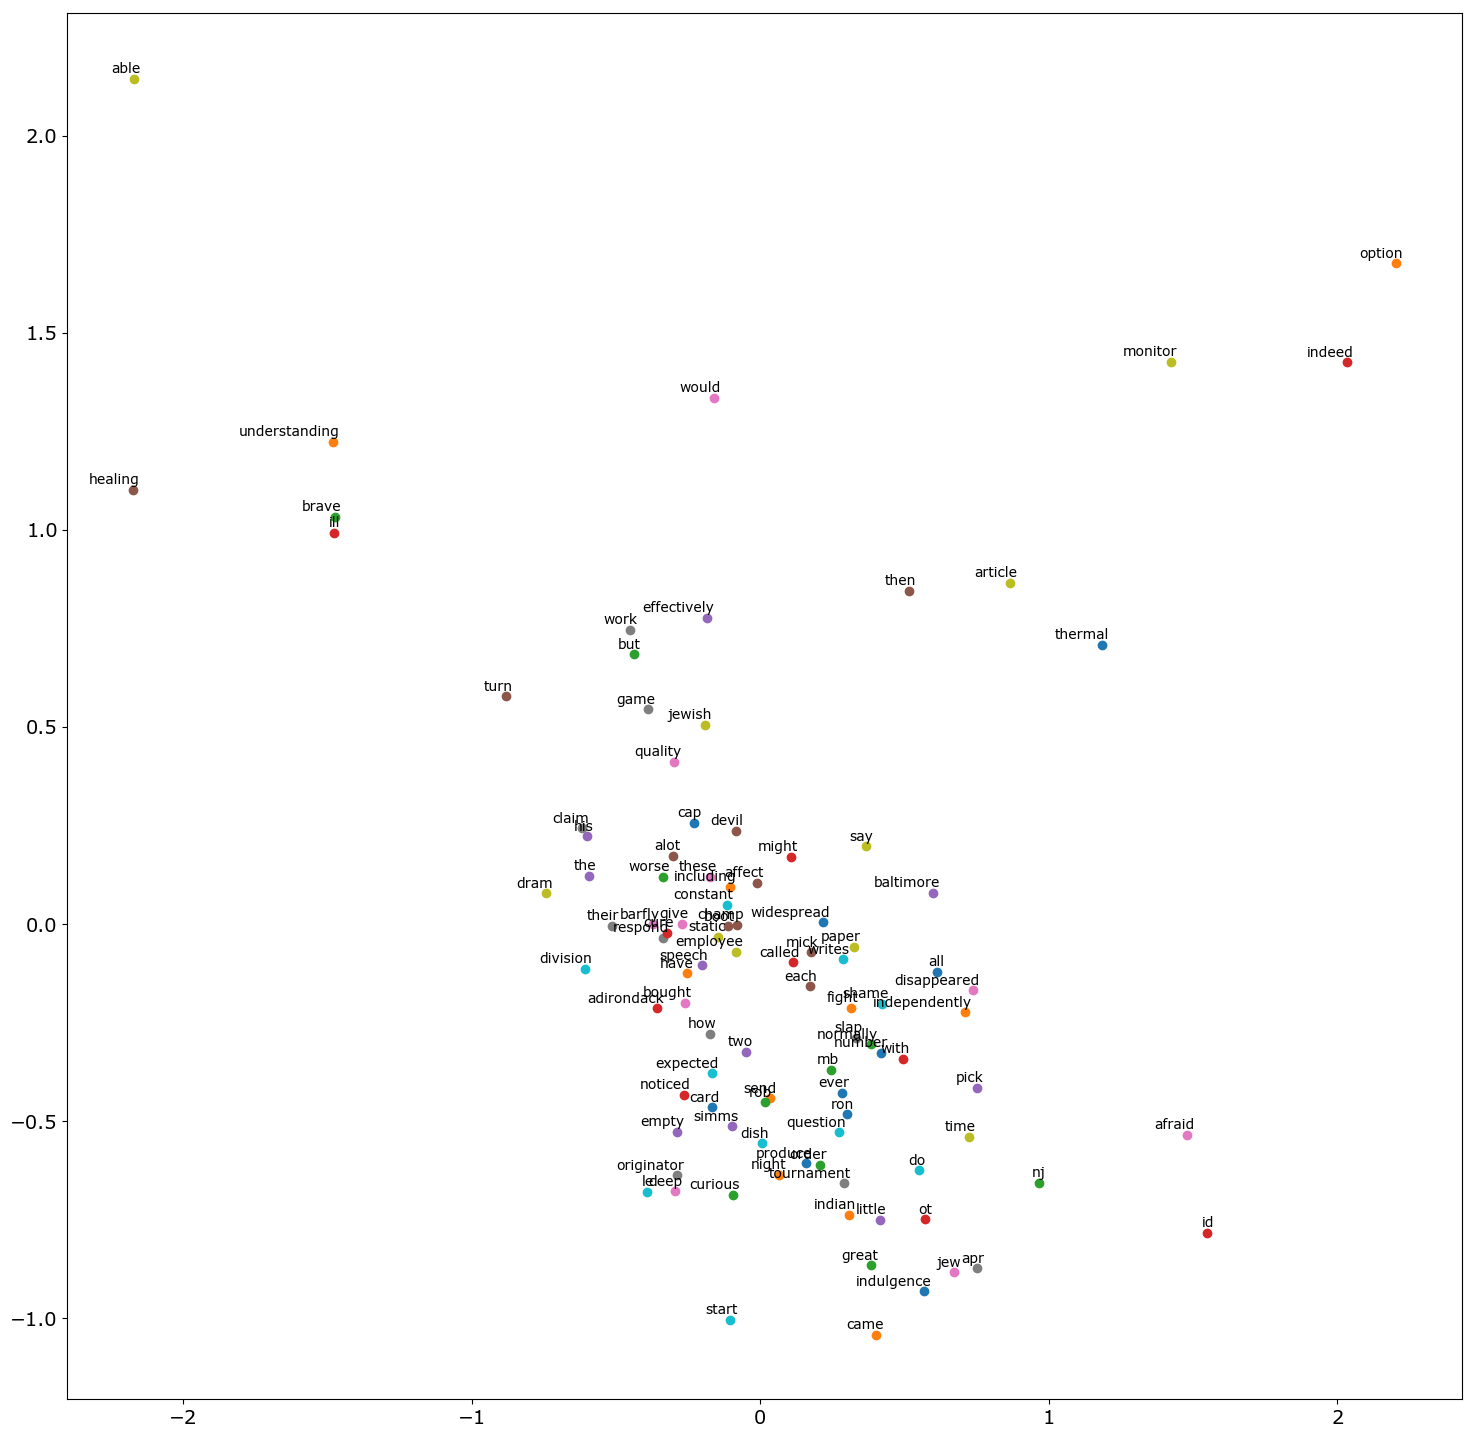

In [272]:
# Рисуем только первые 100 слов.
labels_to_draw = [labels2[i] for i in range(num_words_to_draw2)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)

### Попробуем с помощью нашей модели улучшить качество кластеризации текстов
Если вы не знаете, что такое кластеризация - почитать об этом можно по [ссылке](http://scikit-learn.org/stable/modules/clustering.html).

Если вам все равно кажется, что это сложно, и вы чувствуете себя более уверено в задаче классификации - вместо задачи кластеризации можно рассматривать задачу классификации - тогда вместо функции quality используйте roc-auc из библиотеки scikit-learn, все остальные шаги предобработки и измерения признаков аналогичны.

Измерять качество кластеризации будем следующим образом - измерим количество правильных попаданий категории в кластеры.

In [55]:
def quality(preds, target):
    permutations = list(itertools.permutations([0, 1, 2]))
    scores = []
    for a, b, c in permutations:
        mapping = {2 : a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
        scores.append(float(sum(mapped_preds != target)) / len(target))
    return 1 - min(scores)

### Пункт 4
Кластеризуйте датасет с заданием признаков с помощью one hot encoding - посмотрите на результат.

Несколько часов было потрачено на то, чтобы разобраться как же сделать one hot encoding. В сети, на стаке почему-то нет особо инфы для нашего случая. Есть ощущение, что так не делают

Попытка реализовать one hot encoder. На мини данных даже удачная, на больших комп повис, увы

In [73]:
answer = []
for z in data_normalized
    for i in z: 
        onehot = [0]*len(x)
        if mylist[mylist == i]:
            onehot[mylist.index('{}'.format(i))] = 1
        answer.append(onehot)

In [77]:
flat_list = [item for sublist in data_normalized for item in sublist]

In [82]:
mylist = list(set(flat_list))

Дальше решил сделать вместо этого CountVectorizer

In [23]:
def dummy(doc):
    return doc

tfidf = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
)  

In [32]:
docs = data_normalized

In [33]:
tfidf.fit(docs)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function dummy at 0x00000228B640CE18>,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function dummy at 0x00000228B640CE18>, vocabulary=None)

In [44]:
v_2 = tfidf.transform(data_normalized)

In [45]:
new = v_2.toarray()

In [43]:
print(v_2.toarray()[1])

[0 0 0 ... 0 0 0]


In [48]:
new.shape

(1777, 24142)

In [50]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(new)

In [56]:
quality(preds, dataset.target)

0.39504783342712435

Как видим, точность очень низкая 

### Пункт 5
Далее кластеризуем тексты на векторах, полученных из модели, которую мы сами обучили.

Напишем функцию, которая делает из предложения вектор - усредняет векторы всех слов в этом предложении. Если слова нет в словаре, то вместо вектора этого слова используется нулевой вектор.

In [119]:
def average_feature_vector(words, model):  
    x = 0
    for word in words: 
        try:
            emb = model[word]
            x += emb
        except: 
            x = x + 0
    average_feature_vector = x/len(words)
    return average_feature_vector

Применим функцию к нашим данным (уже нормализованным функцией normalize).

In [146]:
data_normalized_vectors = [average_feature_vector(sent, model)
                           for sent in data_normalized]

Сначала попробуем PCA

In [147]:
low_dim_vectors = embeddings_2d(data_normalized_vectors)

In [148]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.8244231851435002

Сожмем массив признаков с помощью TSNE до нескольких компонент (попробуйте поварьировать число компонент).

In [149]:
def embeddings_2d_TSNE(embeddings):
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result

In [150]:
low_dim_vectors = embeddings_2d_TSNE(data_normalized_vectors)

Примените алгоритм кластеризации (например, K-means).

In [151]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.963984243106359

Интересно то, что результат с TSNE значительно превосходит результат с PCA

### Пункт 6

Кластеризуйте тексты на векторах, полученных из предобученной модели. Какой результат получился лучше? Почему?

In [152]:
data_normalized_vectors = [average_feature_vector(sent, model_googleNews)
                           for sent in data_normalized]

In [153]:
low_dim_vectors = embeddings_2d(data_normalized_vectors)

In [154]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.7602701181767023

In [160]:
low_dim_vectors = embeddings_2d_TSNE(data_normalized_vectors)

In [161]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors)
quality(preds, dataset.target)

0.9752391671356219

Результат хуже на 6% с PCA и на 1 % лучше с TSNE (ещё было обнаружено, что результаты очень нестабильны, большая вариация). Казалось, что на предобученной модели результат должен быть выше за счёт большей обучающей выборки и соответственно большей точности эмбедингов. Но нет. Причина возможно в том, что наша модель обучалась на специфичных данных, в которых намного чаще встречаются тексты тематически похожие на определяемые нами кластеры. Если так, тогда и кластеры определять она будет лучше. В каком-то смысле это переобучение, которое в данной задаче играет нам на руку

### Пункт 7

Попробуйте получить аналогичные векторы и провести исследование на них с помощью fastq - [неплохое введение](https://www.analyticsvidhya.com/blog/2017/07/word-representations-text-classification-using-fasttext-nlp-facebook/).

Обучаю модель на таких же данных. Данные по 20 news groups взял с https://www.kaggle.com/crawford/20-newsgroups. Датасет разделён по темам и в одном из файлов или нескольких есть символы в другой кодировке. Первый скор это модель обученная только на тексте soc.religion.christian, как видим скор кластеризации низкий 66%. Затем удалось решить проблему с кодировками и обучить на всех трёх текстах, скор 96%, что в сравнении с другими моделями хорошо. Думаю, если взять предобученную или обучить на обширном датасете, то скор будет лучше, чем у предыдущих моделей

In [193]:
model = fasttext.skipgram('soc.religion.christian.txt', 'model')

In [214]:
model_fast = fasttext.skipgram('plain.txt', 'model')

In [215]:
def average_feature_vector_fast(words, model):  
    x = 0
    for word in words: 
        try:
            emb = np.array(model[word])
            x += emb
        except: 
            x = x + 0
    average_feature_vector = x/len(words)
    return average_feature_vector

In [216]:
data_normalized_vectors = [average_feature_vector_fast(sent, model_fast)
                           for sent in data_normalized]

In [217]:
low_dim_vectors_fast = embeddings_2d_TSNE(data_normalized_vectors)

In [206]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors_fast)
quality(preds, dataset.target)

0.6646032639279684

In [218]:
preds = MiniBatchKMeans(n_clusters=3).fit_predict(low_dim_vectors_fast)
quality(preds, dataset.target)

0.9662352279122116